In [1]:
import logging
from tqdm import tqdm
import arviz as az
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import pytensor as pyt
from random import randint
from prophet import Prophet
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

Importing plotly failed. Interactive plots will not work.


In [2]:
NANOSECONDS_TO_SECONDS = 1000 * 1000 * 1000

class MyProphet():
    def __init__(self,
                 n_changepoints=25,
                 changepoints_prior_scale=0.05,
                 changepoint_range=0.8,
                 seasonality_prior_scale=10.0,
                 mcmc_samples=0,
                 k_mean=0,
                 k_sd=5,
                 m_mean=0,
                 m_sd=5,
                 sigma=0.5,
                ):
        self.n_changepoints = n_changepoints
        self.changepoints_prior_scale = changepoints_prior_scale
        self.changepoint_range = changepoint_range
        self.seasonality_prior_scale = seasonality_prior_scale
        self.mcmc_samples = mcmc_samples
        self.k_mean = k_mean
        self.k_sd = k_sd
        self.m_mean = m_mean
        self.m_sd = m_sd
        self.sigma = sigma
        
        self.model = None
        self.init_vals = None
        self.trend_params = None
        self.yearly_seasonality_params = None
        self.weekly_seasonality_params = None
        self.map_approx = None
        self.trace = None
        self.posterior = None
        
        self.data = None
        self.y_min = None
        self.y_max = None
        self.ds_min = None
        self.ds_max = None

    def _scale_data(self):
        self.y_min = 0
        self.y_max = self.data["y"].abs().max()
        self.ds_min = self.data["ds"].min()
        self.ds_max = self.data["ds"].max()

        self.data["y"] = self.data["y"] / self.y_max
        self.data["t"] = (self.data["ds"] - self.ds_min) / (self.ds_max - self.ds_min)
        
    def _process_data(self):
        self.data["ds"] = pd.to_datetime(self.data["ds"])
        self.data.sort_values("ds", inplace=True)
        self._scale_data()

    def _model_init(self):
        i0, i1 = self.data["ds"].idxmin(), self.data["ds"].idxmax()
        T = self.data["t"].iloc[i1] - self.data["t"].iloc[i0]
        k = (self.data["y"].iloc[i1] - self.data["y"].iloc[i0]) / T
        m = self.data["y"].iloc[i0] - k * self.data["t"].iloc[i0]
        delta = np.zeros(self.n_changepoints)
        self.init_vals = {"k": k, "m": m, "delta": delta, "beta_yearly": 0.0, "beta_weekly": 0.0, "sigma": 1.0}

    def _add_trend(self):
        t = np.array(self.data["t"])
        hist_size = int(np.floor(self.data.shape[0] * self.changepoint_range))
        cp_indexes = np.linspace(0, hist_size - 1, self.n_changepoints + 1).round().astype(int)
        s = np.array(self.data.iloc[cp_indexes]["t"].tail(-1))
    
        # * 1 casts the boolean to integers
        A = (t[:, None] > s) * 1
    
        with self.model:
            # initial growth
            k = pm.Normal("k", self.k_mean , self.k_sd, initval=self.init_vals["k"])

            changepoints_prior_scale = self.changepoints_prior_scale
            if self.changepoints_prior_scale is None:
                changepoints_prior_scale = pm.Exponential("tau", 1.5)
        
            # rate of change
            delta = pm.Laplace("delta", 0, changepoints_prior_scale, shape=self.n_changepoints, initval=self.init_vals["delta"])
            # offset
            m = pm.Normal("m", self.m_mean, self.m_sd, initval=self.init_vals["m"])
            gamma = -s * delta
            trend = pm.Deterministic("trend", (k + pyt.tensor.dot(A, delta)) * t + (m + pyt.tensor.dot(A, gamma)))

        return trend, A, s

    def _fourier_series(self, data, period=365.25, series_order=10,):
        # convert to days since epoch
        t = data["ds"].to_numpy(dtype=np.int64) // NANOSECONDS_TO_SECONDS / (3600 * 24.)
    
        x_T = t * np.pi * 2
        fourier_components = np.empty((data["ds"].shape[0], 2 * series_order))
        for i in range(series_order):
            c = x_T * (i + 1) / period
            fourier_components[:, 2 * i] = np.sin(c)
            fourier_components[:, (2 * i) + 1] = np.cos(c)
            
        return fourier_components

    def _get_seasonality_n_x(self, data, period):
        if period == "yearly":
            n = 10
            p = 365.25
        else:  # weekly
            n = 3
            p = 7
            
        return n, self._fourier_series(data, p, n)

    def _add_seasonality(self, period):
        n, x = self._get_seasonality_n_x(self.data, period)
    
        with self.model:
            beta = pm.Normal(f"beta_{period}", mu=0, sigma=self.seasonality_prior_scale, shape=2 * n, initval=np.zeros(2 * n))
            
        return x, beta

    def fit(self, data):
        self.data = data.reset_index(drop=True)
        self._process_data()
        self._model_init()

        self.model = pm.Model()
        with self.model:
            trend, A, s = self._add_trend()
            x_yearly, beta_yearly = self._add_seasonality("yearly")
            x_weekly, beta_weekly = self._add_seasonality("weekly")
            trend += pyt.tensor.dot(x_yearly, beta_yearly) + pyt.tensor.dot(x_weekly, beta_weekly)
            # sigma = pm.HalfCauchy("sigma", 0.5, initval=1)
            sigma = pm.HalfNormal("sigma", self.sigma, initval=self.init_vals["sigma"])
            obs = pm.Normal("obs", mu=trend, sigma=sigma, observed=self.data["y"])
            
            if self.mcmc_samples == 0:
                self.map_approx = pm.find_MAP(progressbar=False, maxeval=1e4)
            else:
                self.trace = pm.sample(self.mcmc_samples, return_inferencedata=True, chains=4)
                # self.posterior = pm.sample_posterior_predictive(trace=self.trace)

        self.trend_params = (trend, A, s)
        self.yearly_seasonality_params = (x_yearly, beta_yearly)
        self.weekly_seasonality_params = (x_weekly, beta_weekly)

    def _det_seasonality_posterior(self, beta, x):
        return np.dot(x, beta.T)

    def _plot_predictions(self, future, y_true=None):
        date = future["ds"].dt.to_pydatetime()
        plt.figure(figsize=(16, 3*6))
        b = 411
        plt.subplot(b)
        plt.title("Predictions")
        plt.plot(date, future["yhat"], lw=0.5)
        plt.scatter(date[:len(self.data)], self.data["y"] * self.y_max, s=0.5, color="black")

        if y_true is not None:
            plt.scatter(date[len(self.data):], y_true, s=0.5, color="green")

        plt.subplot(b + 1)
        plt.title("Trend")
        plt.plot(date, future["trend"], lw=0.5)
        # plt.scatter(date[:len(self.data)], self.data["y"] * self.y_max, s=0.5, color="black")

    def _make_future_df(self, days):
        future = pd.DataFrame({
            "ds": pd.DatetimeIndex(pd.concat((
                self.data["ds"], 
                pd.date_range(self.ds_max, self.ds_max + pd.Timedelta(days, "D"), inclusive="right").to_series(),
            )))
        })
        future["t"] = (future["ds"] - self.ds_min) / (self.ds_max - self.ds_min)
        return future
    
    def _predict_map(self, days, y_true=None, plot=False):
        _, _, s = self.trend_params
        future = self._make_future_df(days)
        new_A = (np.array(future["t"])[:, None] > s) * 1
        
        _, x_yearly = self._get_seasonality_n_x(future, "yearly")
        _, x_weekly = self._get_seasonality_n_x(future, "weekly")
        
        future["yearly"] = self._det_seasonality_posterior(self.map_approx["beta_yearly"], x_yearly) * self.y_max
        future["weekly"] = self._det_seasonality_posterior(self.map_approx["beta_weekly"], x_weekly) * self.y_max        
        future["trend"] = np.array((
            (self.map_approx["k"] + np.dot(new_A, self.map_approx["delta"])) * future["t"] + 
            (self.map_approx["m"] + np.dot(new_A, (-s * self.map_approx["delta"])))
        ) * self.y_max)

        future["yhat"] = future["trend"] + future["yearly"] + future["weekly"]

        if plot:
            self._plot_predictions(future, y_true)
            
        return future

    def _predict_mcmc(self, days, y_true=None, plot=False):
        _, _, s = self.trend_params
        future = self._make_future_df(days)
        new_A = (np.array(future["t"])[:, None] > s) * 1

        _, x_yearly = self._get_seasonality_n_x(future, "yearly")
        _, x_weekly = self._get_seasonality_n_x(future, "weekly")
        
        beta_yearly = self.trace["posterior"]["beta_yearly"].to_numpy().mean(0)
        beta_weekly = self.trace["posterior"]["beta_weekly"].to_numpy().mean(0)
        delta = self.trace["posterior"]["delta"].mean(["chain", "draw"])
        k = self.trace["posterior"]["k"].mean().to_numpy()
        m = self.trace["posterior"]["m"].mean().to_numpy()
        
        trend_forecast = []
        
        yearly_posterior = self._det_seasonality_posterior(beta_yearly, x_yearly) * self.y_max
        weekly_posterior = self._det_seasonality_posterior(beta_weekly, x_weekly) * self.y_max

        # TODO: fix this, loop makes no sense
        for n in range(self.mcmc_samples):
            trend_forecast.append(((k + np.dot(new_A, delta)) * future["t"]  + (m + np.dot(new_A, (-s * delta)))) * self.y_max)   
            
        trend_forecast = np.array(trend_forecast)
        
        future["yhat"] = (trend_forecast + yearly_posterior.T + weekly_posterior.T).mean(0)
        future["trend"] = trend_forecast.mean(0)
        future["yearly"] = yearly_posterior.T.mean(0)
        future["weekly"] = weekly_posterior.T.mean(0)

        if plot:
            self._plot_predictions(future, y_true)
        
        return future

class MyProphetWrapper():
    def __init__(self,
                 n_changepoints=25,
                 changepoints_prior_scale=0.05,
                 changepoint_range=0.8,
                 seasonality_prior_scale=10.0,
                 mcmc_samples=0,
                 k_mean=0,
                 k_sd=5,
                 m_mean=0,
                 m_sd=5,
                 sigma=0.5,
                ):
        self.n_changepoints = n_changepoints
        self.changepoints_prior_scale = changepoints_prior_scale
        self.changepoint_range = changepoint_range
        self.seasonality_prior_scale = seasonality_prior_scale
        self.mcmc_samples = mcmc_samples
        self.k_mean = k_mean
        self.k_sd = k_sd
        self.m_mean = m_mean
        self.m_sd = m_sd
        self.sigma = sigma

    def _calculate_metrics(self, ys, yhats, horizon):
        metrics = {"horizon": [], "mse": [], "rmse": [], "mae": [], "mape": []}

        for k in tqdm(range(horizon)):
            y_true = [y[y["day_idx"] == k]["y"].values[0] for y in ys if k in y["day_idx"].values]
            y_pred = [y[y["day_idx"] == k]["y"].values[0] for y in yhats if k in y["day_idx"].values]
            
            metrics["horizon"].append(k + 1)
            metrics["mse"].append(mean_squared_error(y_true, y_pred))
            metrics["rmse"].append(root_mean_squared_error(y_true, y_pred))
            metrics["mae"].append(mean_absolute_error(y_true, y_pred))
            metrics["mape"].append(mean_absolute_percentage_error(y_true, y_pred))

        return pd.DataFrame.from_dict(metrics)

    def test_prophet(self, df, window=730, horizon=365, extend_window=False, limit=None):
        yhats = []
        ys = []

        l = len(df) - window - horizon - 1
        if limit is not None:
            l = limit
        
        for start in tqdm(range(l)):
            model = Prophet(
                n_changepoints=self.n_changepoints,
                changepoint_prior_scale=self.changepoints_prior_scale,
                changepoint_range=self.changepoint_range,
                seasonality_prior_scale=self.seasonality_prior_scale,
            )

            if extend_window:
                model.fit(df[:start + window])
            else:
                model.fit(df[start:start + window])

            future = model.make_future_dataframe(periods=horizon, include_history=False)
            
            y = df[start + window:start + window + horizon].copy()
            y["ds"] = pd.to_datetime(y["ds"])
            yhat = model.predict(future)
        
            y = y[y["ds"].isin(yhat["ds"])]
            yhat = yhat[yhat["ds"].isin(y["ds"])]
        
            y["day_idx"] = (y["ds"] - y["ds"].min()).dt.days
            ys.append(y)
        
            yhat["day_idx"] = (yhat["ds"] - yhat["ds"].min()).dt.days
            yhat["y"] = yhat["yhat"]
            yhat.drop(yhat.columns.difference(["ds", "y", "day_idx"]), axis=1, inplace=True)
            yhats.append(yhat)
        

        return self._calculate_metrics(ys, yhats, horizon)

    def test_my_prophet(self, df, update_priors_days=1, window=730, horizon=365, extend_window=False, limit=None):
        yhats = []
        ys = []
        
        k_mean = self.k_mean
        k_sd = self.k_sd
        m_mean = self.m_mean
        m_sd = self.m_sd
        sigma = self.sigma

        l = len(df) - window - horizon - 1
        if limit is not None:
            l = limit
        
        for start in tqdm(range(l)):
            if update_priors_days > 0 and start % update_priors_days == 0:
                mcmc_samples = self.mcmc_samples
            else:
                mcmc_samples = 0
        
            model = MyProphet(
                n_changepoints=self.n_changepoints,
                changepoints_prior_scale=self.changepoints_prior_scale,
                changepoint_range=self.changepoint_range,
                seasonality_prior_scale=self.seasonality_prior_scale,
                mcmc_samples=mcmc_samples,
                k_mean=k_mean,
                k_sd=k_sd,
                m_mean=m_mean,
                m_sd=m_sd,
                sigma=sigma,
            )

            if extend_window:
                model.fit(df[:start + window])
            else:
                model.fit(df[start:start + window])
            
            y = df[start + window:start + window + horizon].copy()
            y["ds"] = pd.to_datetime(y["ds"])
            yhat = model._predict_map(horizon) if mcmc_samples == 0 else model._predict_mcmc(horizon)
        
            y = y[y["ds"].isin(yhat["ds"])]
            yhat = yhat[yhat["ds"].isin(y["ds"])]
        
            y["day_idx"] = (y["ds"] - y["ds"].min()).dt.days
            ys.append(y)
        
            yhat["day_idx"] = (yhat["ds"] - yhat["ds"].min()).dt.days
            yhat["y"] = yhat["yhat"]
            yhat.drop(yhat.columns.difference(["ds", "y", "day_idx"]), axis=1, inplace=True)
            yhats.append(yhat)
        
            if update_priors_days > 0 and start % update_priors_days == 0:
                if self.mcmc_samples == 0:
                    k_mean = model.map_approx["k"]
                    # k_sd = summary["sd"]["k"]
                    m_mean = model.map_approx["m"]
                    # m_sd = summary["sd"]["m"]
                    # sigma = summary["sd"]["sigma"]
                else:
                    summary = az.summary(model.trace, var_names=["k", "m", "sigma"])
                    
                    k_mean = summary["mean"]["k"]
                    # k_sd = summary["sd"]["k"]
                    m_mean = summary["mean"]["m"]
                    # m_sd = summary["sd"]["m"]
                    # sigma = summary["sd"]["sigma"]
                
                # print(k_mean, k_sd, m_mean, m_sd, sigma)

        return self._calculate_metrics(ys, yhats, horizon)

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv")
df

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572
...,...,...
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871


/tmp/ipykernel_100274/1126600857.py:150: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date = future["ds"].dt.to_pydatetime()


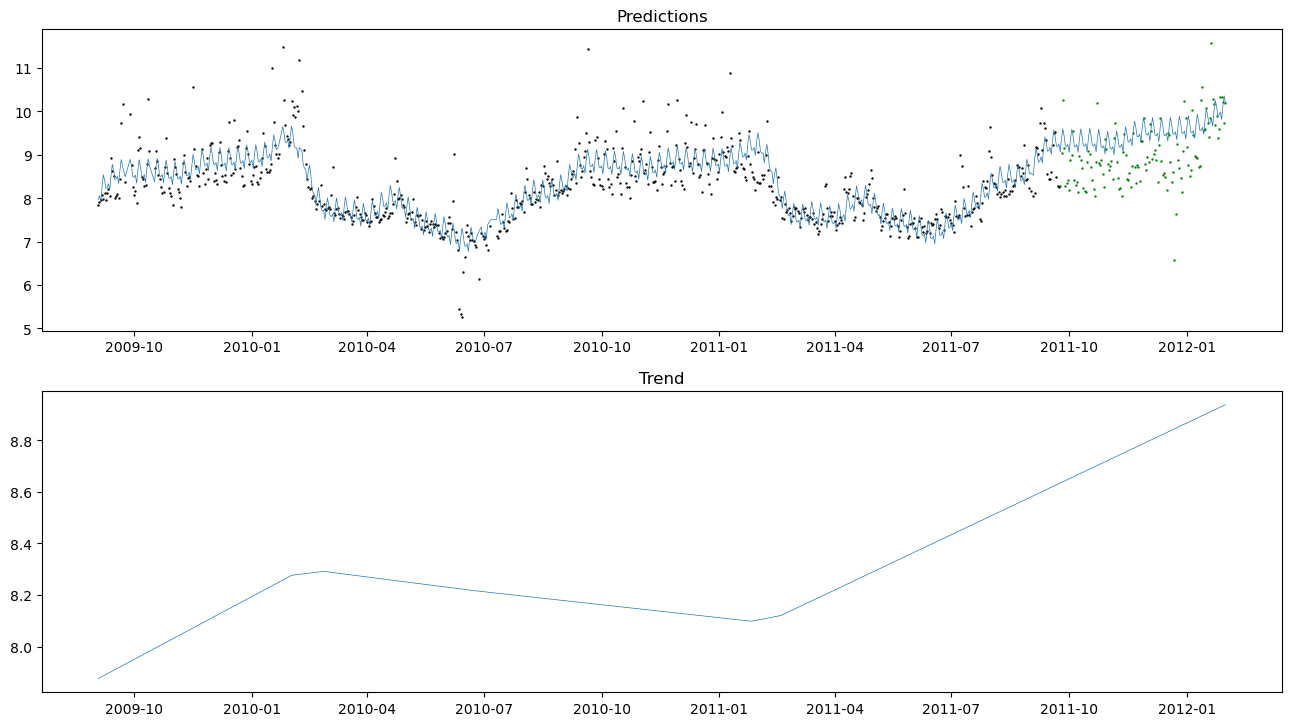

In [4]:
window = 730
horizon = 130
start = randint(0, len(df) - window - horizon - 1)

my_model = MyProphet()
my_model.fit(df[start:start + window])
preds = my_model._predict_map(horizon, y_true=df[start + window:start + window + horizon]["y"], plot=True)

/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


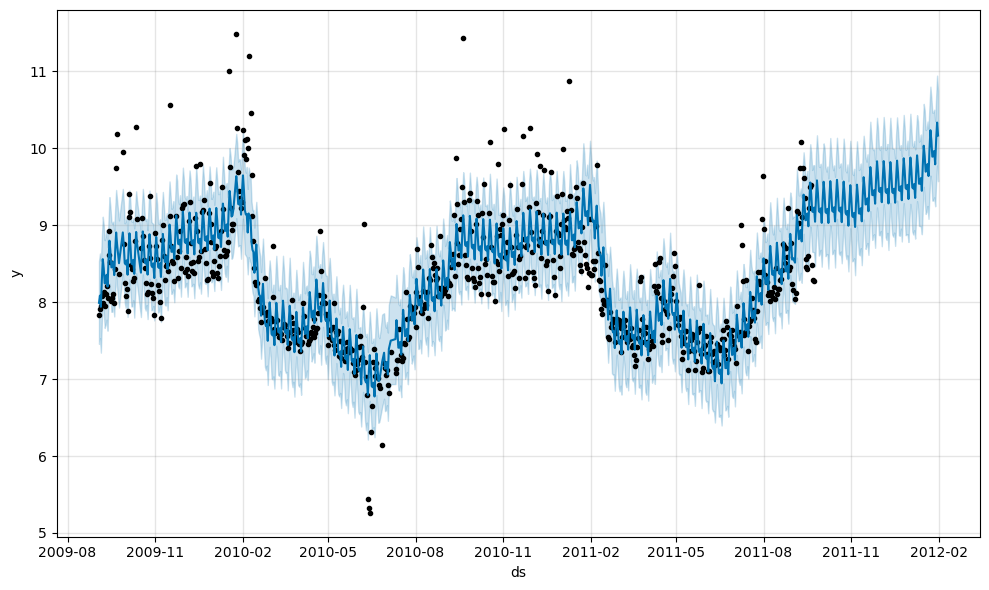

In [5]:
model = Prophet()
model.fit(df[start:start + window])
future = model.make_future_dataframe(periods=horizon, include_history=True)
forecast = model.predict(future)
fig = model.plot(forecast)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 265 seconds.
/tmp/ipykernel_100274/1126600857.py:150: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date = future["ds"].dt.to_pydatetime()


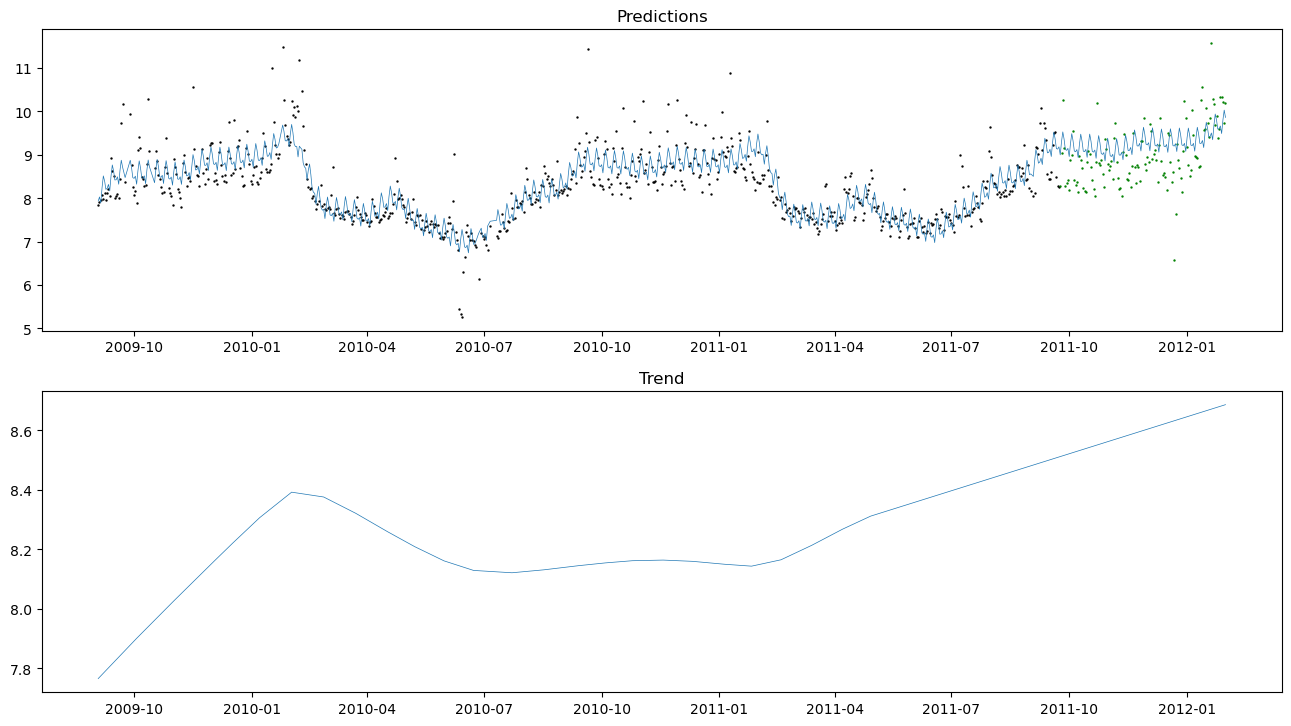

In [7]:
model = MyProphet(mcmc_samples=1000)
model.fit(df[start:start + window])
mcmc_preds = model._predict_mcmc(horizon, y_true=df[start + window:start + window + horizon]["y"], plot=True)

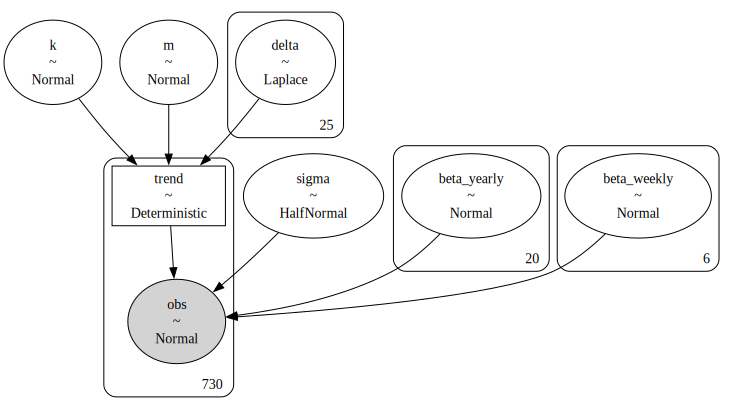

In [8]:
pm.model_to_graphviz(my_model.model)

/tmp/ipykernel_100274/1126600857.py:150: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date = future["ds"].dt.to_pydatetime()


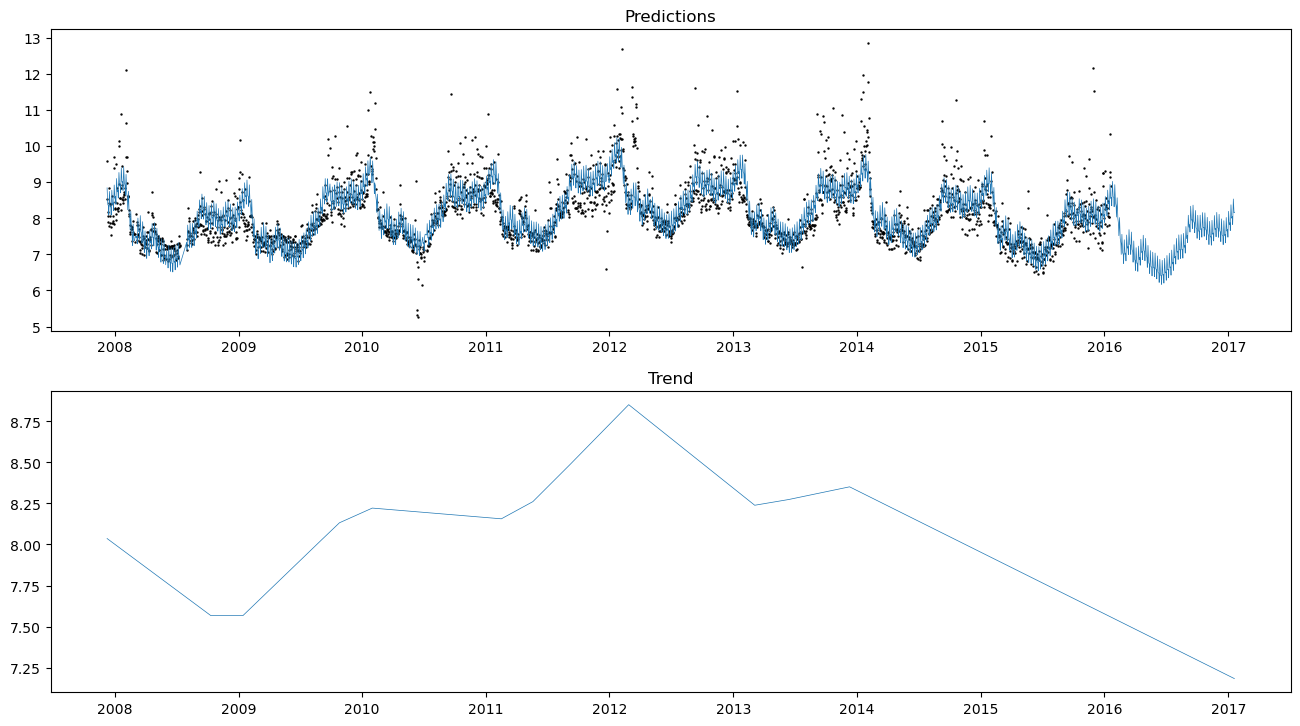

In [9]:
my_model = MyProphet()
my_model.fit(df)
full_preds = my_model._predict_map(365, plot=True)

/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime o

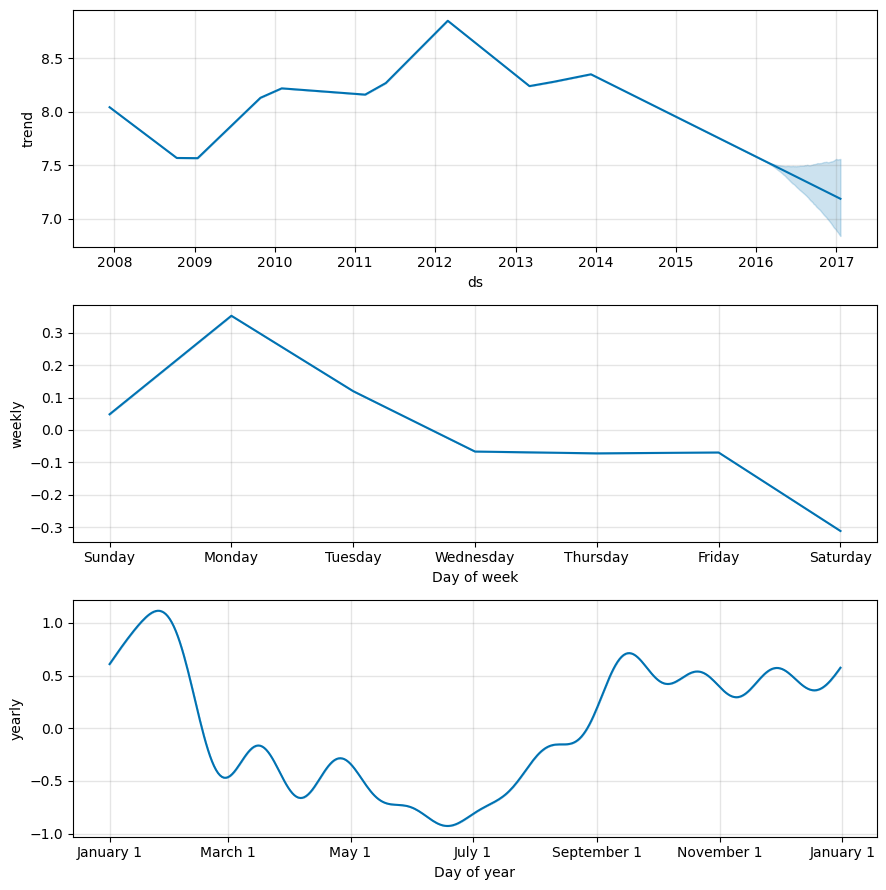

In [10]:
model = Prophet()
model.fit(df)
future = model.make_future_dataframe(periods=365, include_history=True)
full_forecast = model.predict(future)
fig = model.plot_components(full_forecast)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1590 seconds.
/tmp/ipykernel_100274/1126600857.py:150: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date = future["ds"].dt.to_pydatetime()


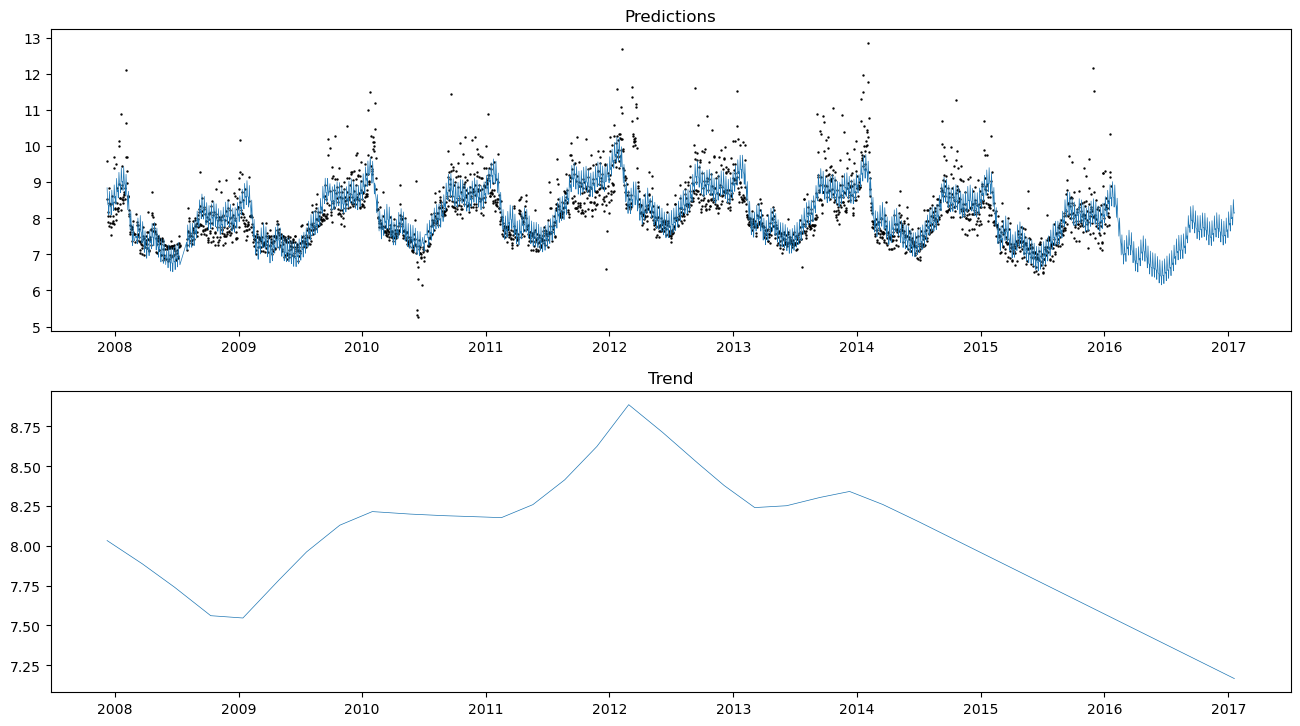

In [11]:
my_model = MyProphet(mcmc_samples=1000)
my_model.fit(df)
full_preds_mcmc = my_model._predict_mcmc(365, plot=True)

array([[<Axes: title={'center': 'k'}>, <Axes: title={'center': 'k'}>],
       [<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>],
       [<Axes: title={'center': 'm'}>, <Axes: title={'center': 'm'}>],
       [<Axes: title={'center': 'beta_yearly'}>,
        <Axes: title={'center': 'beta_yearly'}>],
       [<Axes: title={'center': 'beta_weekly'}>,
        <Axes: title={'center': 'beta_weekly'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'trend'}>,
        <Axes: title={'center': 'trend'}>]], dtype=object)

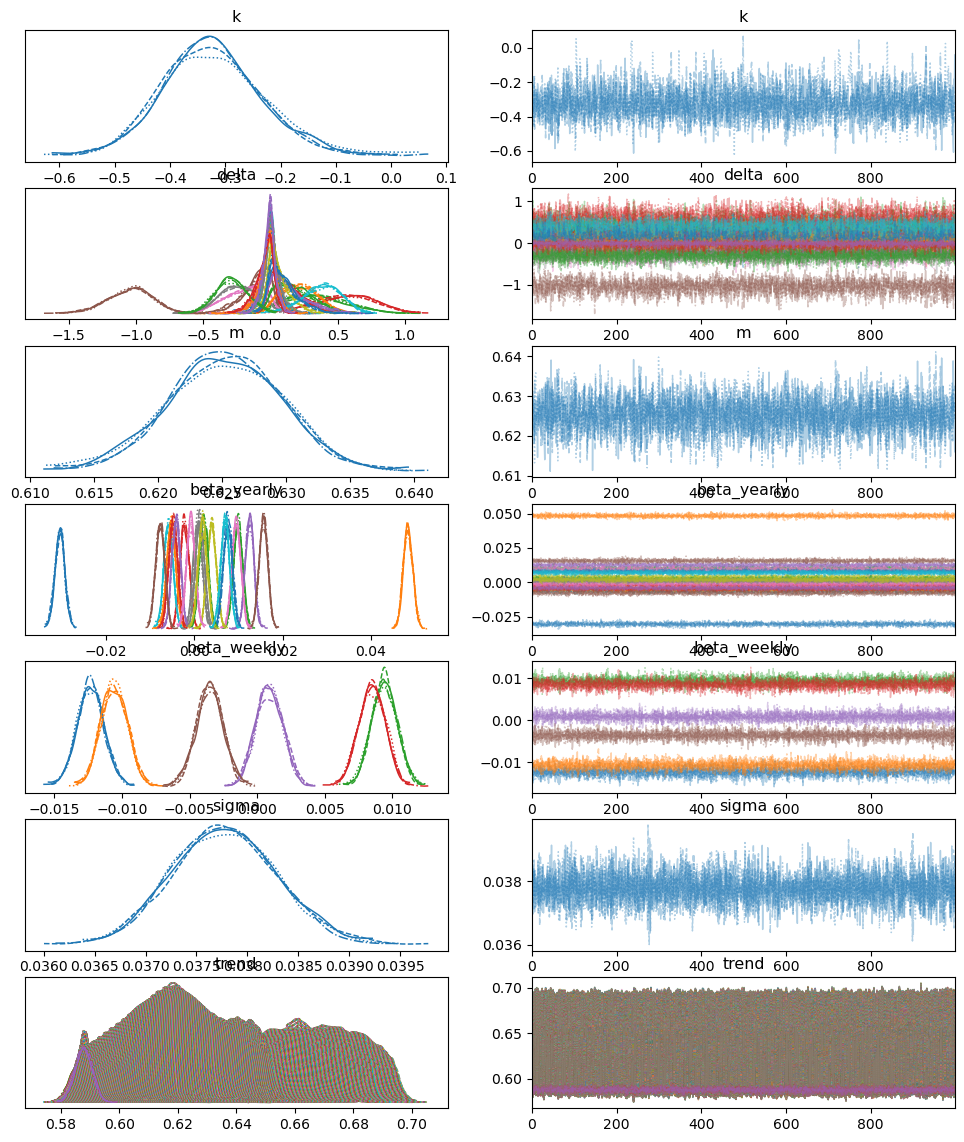

In [13]:
pm.plot_trace(my_model.trace)

In [15]:
mean_absolute_percentage_error(df["y"], full_forecast["yhat"][:len(df)])

0.039984054963658866

In [16]:
mean_absolute_percentage_error(df["y"], full_preds["yhat"][:len(df)])

0.039972950848663216

In [17]:
mean_absolute_percentage_error(df["y"], full_preds_mcmc["yhat"][:len(df)])

0.03987105807422909

# Compare

In [ ]:
model_wrapper = MyProphetWrapper()
prophet_preds = model_wrapper.test_prophet(df, extend_window=False)
prophet_preds

  3%|█████▉                                                                                                                                                                    | 63/1809 [00:10<04:28,  6.50it/s]

In [ ]:
my_preds = model_wrapper.test_my_prophet(df, extend_window=False, update_priors_days=0)
my_preds

In [ ]:
prophet_extended_preds = model_wrapper.test_prophet(df, extend_window=True)
prophet_extended_preds

In [ ]:
my_extended_preds = model_wrapper.test_my_prophet(df, extend_window=True, update_priors_days=0)
my_extended_preds

In [ ]:
update_priors_preds = model_wrapper.test_prophet(df, extend_window=False, update_priors_days=1)
update_priors_preds